# Neighborhood-Based Collaborative Filtering

Uno dei principi alla base degli algoritmi di raccomandazione è il **filtraggio collaborativo**, che sfrutta i comportamenti di valutazione storici per individuare somiglianze tra utenti e/o elementi e, quindi, arrivare a predizioni delle valutazioni. In questa sede, analizziamo un approccio semplice ma altamente intuitivo al filtraggio collaborativo, fondato sul concetto di **vicinato**.  

Questo metodo non solo illustra chiaramente il principio del filtraggio collaborativo, ossia il collegamento tra utenti ed elementi attraverso la ricerca di similarità, ma offre anche un elevato livello di interpretabilità, come vedremo in questo tutorial.  

## 1. Setup

In [24]:
!pip install --quiet cornac==1.15.4
!pip install pandas
!pip install seaborn

In [25]:
import os
import sys
import textwrap
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Cornac version: 1.15.4


## 2. Dati di esempio

A scopo illustrativo, utilizziamo un semplice set di dati con 5 utenti e 6 oggetti.

In [26]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"),
  sep=",", names=["UserID", "ItemID", "Rating"]
)
sample_df.head()

,UserID,ItemID,Rating
0,1,1,7
1,1,2,6
2,1,3,7
3,1,4,4
4,1,5,5


### Matrice dei ratings

Vediamo questo set di dati di esempio in forma di matrice.


In [27]:
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
df = pd.DataFrame(dataset.matrix.A,
                  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
                  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])
df.replace(0, np.nan, inplace=True)
df["Mean Rating"] = df.mean(axis=1)
df

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Mean Rating
User 1,7.0,6.0,7.0,4.0,5.0,4.0,5.5
User 2,6.0,7.0,NaN,4.0,3.0,4.0,4.8
User 3,NaN,3.0,3.0,1.0,1.0,NaN,2.0
User 4,1.0,2.0,2.0,3.0,3.0,4.0,2.5
User 5,1.0,NaN,1.0,2.0,3.0,3.0,2.0


### Matrice di valutazione centrata sulla media

Uno dei problemi legati ai dati di valutazione è la loro natura soggettiva. In particolare, utenti diversi potrebbero utilizzare scale di valori differenti. Alcuni utenti tendono a essere più indulgenti, assegnando valutazioni più alte, mentre altri sono più severi e assegnano punteggi più bassi. Un approccio comunemente adottato per *normalizzare* queste valutazioni consiste nel calcolare la media delle valutazioni di ciascun utente e sottrarre tale media dalle singole valutazioni fornite dallo stesso utente.

In [28]:
ratings = df[df.columns.difference(["Mean Rating"])].values
means = df["Mean Rating"].values[:, np.newaxis]
df[df.columns.difference(["Mean Rating"])] = (ratings - means)
df.drop(columns="Mean Rating")

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,1.5,0.5,1.5,-1.5,-0.5,-1.5
User 2,1.2,2.2,NaN,-0.8,-1.8,-0.8
User 3,NaN,1.0,1.0,-1.0,-1.0,NaN
User 4,-1.5,-0.5,-0.5,0.5,0.5,1.5
User 5,-1.0,NaN,-1.0,0.0,1.0,1.0


### 3. **Metodi Basati sull'Utente**

Per ciascun utente, la valutazione media viene calcolata come segue:

$$
\mu_u = \frac{\sum_{k \in \mathcal{I}_u} r_{uk}}{|\mathcal{I}_u|} \ \ \forall u \in \{1, \dots, m\}
$$

dove $ \mathcal{I}_u $ è l'insieme degli elementi valutati dall'utente $ u $, e $ r_{uk} $ rappresenta la valutazione dell'utente $ u $ per l'elemento $ k $.

### **Similarità tra Utenti**

Esistono due approcci comuni per misurare la similarità tra due utenti $ \mathrm{Sim}(u, v) $: **Similarità Coseno** e **Coefficiente di Correlazione di Pearson**.

#### **Similarità Coseno**
Misura l'angolo tra due vettori di valutazioni:

$$
\mathrm{Cosine}(u,v) = \frac{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk} \cdot r_{vk}}{\sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk}^2} \cdot \sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{vk}^2}}
$$


#### **Correlazione di Pearson**
Misura la correlazione lineare tra le valutazioni degli utenti, centrando le valutazioni rispetto alla media:

$$
\mathrm{Pearson}(u,v) = \frac{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u) \cdot (r_{vk} - \mu_v)}{\sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u)^2} \cdot \sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{vk} - \mu_v)^2}}
$$

### **Esempio di Calcolo tra Utente 1 e Utente 3**

Dati i valori di valutazione della matrice, calcoliamo la similarità tra **Utente 1** e **Utente 3**:

1. **Similarità Coseno**

$$
\mathrm{Cosine}(1,3) = \frac{6 \cdot 3 + 7 \cdot 3 + 4 \cdot 1 + 5 \cdot 1}{\sqrt{6^2 + 7^2 + 4^2 + 5^2} \cdot \sqrt{3^2 + 3^2 + 1^2 + 1^2}}
$$

Calcoliamo passo per passo:

- Numeratore: $ 6 \cdot 3 + 7 \cdot 3 + 4 \cdot 1 + 5 \cdot 1 = 18 + 21 + 4 + 5 = 48 $
- Denominatore: $ \sqrt{6^2 + 7^2 + 4^2 + 5^2} = \sqrt{36 + 49 + 16 + 25} = \sqrt{126} $  
  $ \sqrt{3^2 + 3^2 + 1^2 + 1^2} = \sqrt{9 + 9 + 1 + 1} = \sqrt{20} $

$$
\mathrm{Cosine}(1,3) = \frac{48}{\sqrt{126} \cdot \sqrt{20}} \approx 0.956
$$


2. **Correlazione di Pearson**

$$
\mathrm{Pearson}(1,3) = \frac{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u) \cdot (r_{vk} - \mu_v)}{\sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u)^2} \cdot \sqrt{\sum_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{vk} - \mu_v)^2}}
$$

Passo per passo:

- Media di $ \mathrm{User \ 1} $: $ \mu_1 = \frac{6 + 7 + 4 + 5}{4} = 5.5 $
- Media di $ \mathrm{User \ 3} $: $ \mu_3 = \frac{3 + 3 + 1 + 1}{4} = 2 $

Calcolo delle differenze centrali:

- $ r_{1k} - \mu_1 $ (User 1): $ 6 - 5.5 = 0.5, \ 7 - 5.5 = 1.5, \ 4 - 5.5 = -1.5, \ 5 - 5.5 = -0.5 $
- $ r_{3k} - \mu_3 $ (User 3): $ 3 - 2 = 1, \ 3 - 2 = 1, \ 1 - 2 = -1, \ 1 - 2 = -1 $

Prodotto delle differenze:

- Numeratore: $ (0.5)(1) + (1.5)(1) + (-1.5)(-1) + (-0.5)(-1) = 0.5 + 1.5 + 1.5 + 0.5 = 4 $

Denominatore:

- Deviazione User 1: $ \sqrt{0.5^2 + 1.5^2 + (-1.5)^2 + (-0.5)^2} = \sqrt{0.25 + 2.25 + 2.25 + 0.25} = \sqrt{5} $
- Deviazione User 3: $ \sqrt{1^2 + 1^2 + (-1)^2 + (-1)^2} = \sqrt{1 + 1 + 1 + 1} = \sqrt{4} $

$$
\mathrm{Pearson}(1,3) = \frac{4}{\sqrt{5} \cdot \sqrt{4}} = \frac{4}{\sqrt{20}} \approx 0.894
$$

### **Conclusione**
I valori calcolati sono:

- **Similarità del Coseno**: $ 0.956 $
- **Correlazione di Pearson**: $ 0.894 $

Questi risultati riflettono due diverse misure di similarità tra i vettori di valutazione dei due utenti.

In [29]:
uknn_cosine = UserKNN(k=2, similarity="cosine", verbose=VERBOSE).fit(dataset)
print(f"Cosine(1,3) = {uknn_cosine.sim_mat[0, 2]:.3f}")

uknn_pearson = UserKNN(k=2, similarity="pearson", verbose=VERBOSE).fit(dataset)
print(f"Pearson(1,3) = {uknn_pearson.sim_mat[0, 2]:.3f}")

Cosine(1,3) = 0.956
Pearson(1,3) = 0.894


In questo contesto, utilizziamo la **media ponderata delle valutazioni centrate sulla media** per effettuare una previsione. La **funzione di previsione** basata sul metodo di *vicinato* è definita come segue:

$$
\hat{r}_{uj} = \mu_u + \frac{\sum_{v \in P_u(j)} \mathrm{Sim}(u,v) \cdot (r_{vj} - \mu_v)}{\sum_{v \in P_u(j)} |\mathrm{Sim}(u,v)|}
$$

dove:  
- $\hat{r}_{uj}$ è la valutazione prevista dell'*Utente $u$* per l'*Oggetto $j$*;  
- $\mu_u$ è la media delle valutazioni date dall'Utente $u$;  
- $P_u(j)$ rappresenta l'insieme degli utenti "vicini" a $u$ che hanno valutato l'oggetto $j$;  
- $\mathrm{Sim}(u,v)$ è la similarità tra l'Utente $u$ e l'Utente $v$;  
- $r_{vj}$ è la valutazione data dall'Utente $v$ all'Oggetto $j$;  
- $\mu_v$ è la media delle valutazioni date dall'Utente $v$.  


### Esempio pratico  
Consideriamo il caso di previsione delle valutazioni che l'*Utente 3* darà agli *Oggetti 1* e *6*. I dati si basano sui due vicini più prossimi: *Utente 1* e *Utente 2*.

#### Calcolo per l'Oggetto 1  
$$
\hat{r}_{31} = \mu_3 + \frac{\mathrm{Sim}(3,1) \cdot (r_{11} - \mu_1) + \mathrm{Sim}(3,2) \cdot (r_{21} - \mu_2)}{\mathrm{Sim}(3,1) + \mathrm{Sim}(3,2)}
$$

Sostituendo i valori numerici:  
$$
\hat{r}_{31} = 2 + \frac{1.5 \cdot 0.894 + 1.2 \cdot 0.939}{0.894 + 0.939} = 3.35
$$


#### Calcolo per l'Oggetto 6  
$$
\hat{r}_{36} = \mu_3 + \frac{\mathrm{Sim}(3,1) \cdot (r_{16} - \mu_1) + \mathrm{Sim}(3,2) \cdot (r_{26} - \mu_2)}{\mathrm{Sim}(3,1) + \mathrm{Sim}(3,2)}
$$

Sostituendo i valori numerici:  
$$
\hat{r}_{36} = 2 + \frac{-1.5 \cdot 0.894 - 0.8 \cdot 0.939}{0.894 + 0.939} = 0.86
$$

### Verifica del calcolo  
Le previsioni ottenute sono:  
- Per l'**Oggetto 1**: $ \hat{r}_{31} = 3.35 $  
- Per l'**Oggetto 6**: $ \hat{r}_{36} = 0.86 $

Questi risultati confermano la correttezza del metodo di previsione applicato.

In [30]:
print(f"R(3,1) = {uknn_pearson.score(user_idx=2, item_idx=0):.2f}")
print(f"R(3,6) = {uknn_pearson.score(user_idx=2, item_idx=5):.2f}")

R(3,1) = 3.35
R(3,6) = 0.86


### Proviamo con un Dataset Reale

Ora applicheremo questi algoritmi al dataset [MovieLens](https://grouplens.org/datasets/movielens/). La nostra convenzione prevede l'utilizzo delle valutazioni centrate sulla media quando aggreghiamo le valutazioni dei vicini per produrre una previsione, correggendo poi in seguito per la media. Tuttavia, il calcolo della similarità può essere basato sia sulle valutazioni originali che su quelle centrate sulla media, come mostrato nelle varianti seguenti.

In [31]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.9102 |    0.1570 |   5.2571
UserKNN-Cosine-MC  | 0.8947 |    0.2242 |   3.5629
UserKNN-Pearson    | 0.8947 |    0.2985 |   3.7476
UserKNN-Pearson-MC | 0.8947 |    0.4137 |   6.0025



Le similarità del coseno e *Pearson* possono essere applicate anche ai metodi *item-based*, con la differenza che i vettori di caratteristiche da considerare sono ora rappresentati dalle colonne anziché dalle righe, poiché stiamo misurando la similarità tra elementi.

Quando la similarità del coseno è calcolata utilizzando una matrice di valutazioni *centrata sulla media*, otteniamo una variante chiamata **Adjusted Cosine**. La formula della similarità *Adjusted Cosine* tra due elementi (colonne) $ i $ e $ j $ è definita come:

$$
\mathrm{AdjustedCosine}(i,j) = \frac{\sum_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui} \cdot s_{uj}}{\sqrt{\sum_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui}^2} \cdot \sqrt{\sum_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{uj}^2}}
$$

dove $ s_{ui} $ rappresenta la valutazione *centrata sulla media* fornita dall'utente $ u $ per l'elemento $ i $.

### Esempio
Consideriamo un esempio basato su un piccolo set di dati, dove vogliamo calcolare la similarità *Adjusted Cosine* tra **Elemento 1** ed **Elemento 3**. La formula applicata è la seguente:

$$
\mathrm{AdjustedCosine}(1,3) = \frac{1.5 \cdot 1.5 + (-1.5) \cdot (-0.5) + (-1) \cdot (-1)}{\sqrt{1.5^2 + (-1.5)^2 + (-1)^2} \cdot \sqrt{1.5^2 + (-0.5)^2 + (-1)^2}} = 0.912
$$

In questo caso:
- $ 1.5 $, $ -1.5 $, e $ -1 $ rappresentano le valutazioni centrate sulla media per l'Elemento 1.
- $ 1.5 $, $ -0.5 $, e $ -1 $ rappresentano le valutazioni centrate sulla media per l'Elemento 3.

Il risultato finale è una similarità di **0.912**.

In [32]:
iknn_adj = ItemKNN(k=2, similarity="cosine", mean_centered=True, verbose=VERBOSE).fit(dataset)
print(f"AdjustedCosine(1,3) = {iknn_adj.sim_mat[0, 2]:.3f}")

AdjustedCosine(1,3) = 0.912


Per la previsione, utilizziamo la stessa forma della funzione di predizione adottata nei metodi *user-based*, ma aggreghiamo le valutazioni dell'utente sugli elementi vicini:

$$
\hat{r}_{ut} = \mu_u + \frac{\sum_{j \in Q_t(u)} \mathrm{Sim}(j,t) \cdot (r_{uj} - \mu_u)}{\sum_{j \in Q_t(u)} |\mathrm{Sim}(j,t)|}
$$

### Esempio di calcolo
Supponiamo di prevedere le valutazioni che *Utente 3* assegnerebbe a *Elemento 1* e *Elemento 6*.  
Per *Elemento 1*, consideriamo i due vicini più prossimi (*Elemento 2* e *Elemento 3*), mentre per *Elemento 6*, consideriamo *Elemento 4* e *Elemento 5*.

#### Calcolo per *Elemento 1*:
$$
\hat{r}_{31} = 2 + \frac{1 \cdot 0.735 + 1 \cdot 0.912}{0.735 + 0.912} = 3
$$

#### Calcolo per *Elemento 6*:
$$
\hat{r}_{36} = 2 + \frac{(-1) \cdot 0.829 + (-1) \cdot 0.730}{0.829 + 0.730} = 1
$$

In questa equazione, $ s_{ui} $ rappresenta la valutazione *media-centro* che l'utente $ u $ assegna all'elemento $ i $.


### Esempio: Similitudine Coseno Corretto (Adjusted Cosine)
Ad esempio, possiamo calcolare la *similarità coseno corretta* tra *Elemento 1* e *Elemento 3* usando il piccolo dataset campione riportato sopra:

$$
\mathrm{AdjustedCosine}(1,3) = \frac{1.5 \cdot 1.5 + (-1.5) \cdot (-0.5) + (-1) \cdot (-1)}{\sqrt{1.5^2 + (-1.5)^2 + (-1)^2} \cdot \sqrt{1.5^2 + (-0.5)^2 + (-1)^2}} = 0.912
$$

### Spiegazione dei termini:
- $\hat{r}_{ut}$: previsione della valutazione dell'utente $ u $ sull'elemento $ t $.  
- $\mu_u$: valutazione media dell'utente $ u $.  
- $Q_t(u)$: insieme degli elementi vicini (simili a $ t $) valutati dall'utente $ u $.  
- $\mathrm{Sim}(j,t)$: similarità tra l'elemento $ j $ e l'elemento $ t $.  
- $r_{uj}$: valutazione data dall'utente $ u $ all'elemento $ j $.  

L'approccio utilizza la *similarità pesata* tra elementi per prevedere le valutazioni degli utenti sugli elementi target.

In [33]:
print(f"R(3,1) = {iknn_adj.score(user_idx=2, item_idx=0):.1f}")
print(f"R(3,6) = {iknn_adj.score(user_idx=2, item_idx=5):.1f}")

R(3,1) = 3.0
R(3,6) = 1.0


### Proviamo con un Dataset Reale (ADAVER)

In [34]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9687 |    0.3388 |   4.1825
ItemKNN-Pearson        | 0.9624 |    0.5680 |   9.2794
ItemKNN-Pearson-MC     | 0.9573 |    0.5977 |   8.3303
ItemKNN-AdjustedCosine | 0.9099 |    1.6173 |   9.4054



### 5. Ripesatura della Similarità  

Dato che le nostre metriche di similarità sono il *Coseno* o la *Pearson*, i cui valori appartengono all'intervallo $[-1, 1]$, è possibile che i punteggi delle valutazioni varino su scale diverse a seconda della piattaforma. Una pratica comune per aumentare l'*importanza relativa* dei punteggi di similarità consiste nell'uso dell'*amplificazione esponenziale*. Ad esempio, un nuovo punteggio di similarità amplificato basato sulla correlazione *Pearson* può essere definito come:  

$$
\mathrm{Sim}(u, v) = \mathrm{Pearson}(u, v)^{\mathrm{amplify}}
$$

Un ulteriore problema riguarda la distribuzione a coda lunga degli elementi. Alcuni item potrebbero essere molto popolari e, di conseguenza, risultare meno discriminativi tra utenti diversi. Questo fenomeno è ben noto anche nella letteratura sul *Information Retrieval* (IR). Per affrontarlo, possiamo adottare tecniche di *ri-pesatura* delle caratteristiche derivate dall'IR. Una di queste è il concetto di *Inverse Document Frequency (idf)*, che fa parte del modello [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In questo caso, il peso di ciascun elemento $i$ può essere ricalcolato come:  

$$
w_i = \log \bigg( \frac{N}{m_i} \bigg),
$$

dove $N$ rappresenta il numero totale di utenti e $m_i$ è il numero di valutazioni assegnate all'elemento $i$.  

Un'ulteriore evoluzione di questo approccio è il modello [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25), che rappresenta una versione migliorata del TF-IDF. Questo metodo è stato implementato all'interno della libreria *Cornac*.  

In [35]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_base = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Base", verbose=VERBOSE
)
uknn_amp1 = UserKNN(
  k=K, similarity="pearson", amplify=0.5, name="UserKNN-Amp0.5", verbose=VERBOSE
)
uknn_amp2 = UserKNN(
  k=K, similarity="pearson", amplify=3.0, name="UserKNN-Amp3.0", verbose=VERBOSE
)
uknn_idf = UserKNN(
  k=K, similarity="pearson", weighting="idf", name="UserKNN-IDF", verbose=VERBOSE
)
uknn_bm25 = UserKNN(
  k=K, similarity="pearson", weighting="bm25", name="UserKNN-BM25", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_base, uknn_amp1, uknn_amp2, uknn_idf, uknn_bm25],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
UserKNN-Base   | 0.8947 |    0.2103 |   2.6065
UserKNN-Amp0.5 | 0.8934 |    0.9225 |   2.2734
UserKNN-Amp3.0 | 0.9134 |    0.5092 |   1.5934
UserKNN-IDF    | 0.8955 |    0.1172 |   1.4865
UserKNN-BM25   | 0.8956 |    0.1433 |   1.4969



## 6. Interpretazione delle Raccomandazioni

Anziché trattare la previsione delle valutazioni come un'attività opaca e poco trasparente, è più utile comprendere meglio le ragioni dietro determinate raccomandazioni. Per interpretare i risultati delle raccomandazioni in modo più efficace, possiamo analizzare diverse fonti di informazioni, come i **metadati**, il contributo dei singoli "vicini" e l'interazione tra l'utente e gli elementi correlati.

Il dataset **MovieLens 100K** fornisce alcuni tipi di [metadati](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt). Possiamo utilizzare queste informazioni per approfondire le motivazioni delle raccomandazioni. Di seguito, esamineremo il **titolo** dei film e i loro **generi**.

In [36]:
# Download some information of MovieLens 100K dataset
user_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.user"),
  sep="|", names=["UserID", "Age", "Gender", "Occupation", "Zip Code"]
).set_index("UserID")

item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL",
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

### UserKNN (Pearson)
Per i metodi UserKNN, utilizziamo la variante *Pearson* come sistema di raccomandazione. Iniziamo selezionando un utente per esplorare il suo profilo e gli articoli con le valutazioni più alte nel dataset di addestramento.

In [37]:
rating_mat = uknn_pearson.train_set.matrix
user_id2idx = uknn_pearson.train_set.uid_map
user_idx2id = list(uknn_pearson.train_set.user_ids)
item_id2idx = uknn_pearson.train_set.iid_map
item_idx2id = list(uknn_pearson.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = uknn_pearson.train_set.uid_map[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Ad esempio, tra i primi 5 film più apprezzati osservati per *Utente 1*, 2 di questi sono film drammatici.

Le raccomandazioni per questo utente possono essere ottenute nel seguente modo:

In [38]:
recommendations, scores = uknn_pearson.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [6.11605904 5.48557688 5.32202542 5.30147822 5.09619216]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1309,"Very Natural Thing, A (1974)",01-Jan-1974,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
814,"Great Day in Harlem, A (1994)",01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


È interessante, e forse significativo, che delle cinque pellicole previste, tre siano film drammatici.

Per comprendere meglio la natura di questa raccomandazione, vorremmo esaminare come i vicini più prossimi dell'utente contribuiscano alla previsione di ciascun film.

In [39]:
df = defaultdict(list)
sim_arr = uknn_pearson.sim_mat[UIDX].A.ravel()
for rec in recommendations[:TOPK]:
  rated_users = np.array([u for u in range(len(sim_arr)) if rating_mat[u, rec] != 0])
  nearest_neighbor = rated_users[np.argsort(sim_arr[rated_users])[-1:]].item()
  sim = sim_arr[nearest_neighbor]
  score = uknn_pearson.iu_mat[rec, nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["User NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score by the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
pd.DataFrame.from_dict(df)

,Recommendation,User NN,Similarity,Score by the NN,Contribution
0,"Very Natural Thing, A (1974)",703,-0.073508,-2.526316,2.526316
1,"Great Day in Harlem, A (1994)",20,0.471303,1.895833,1.895833
2,Aiqing wansui (1994),190,0.010587,1.732283,1.732283
3,Santa with Muscles (1996),184,0.289477,1.711735,1.711735
4,"Saint of Fort Washington, The (1993)",7,0.467937,1.640909,1.640909


Curiosamente, per la prima raccomandazione di un film, il vicino più prossimo dell'utente è quello che ha una somiglianza negativa con l'utente stesso e che fornisce anche una valutazione negativa per l'oggetto. I due aspetti negativi danno però come risultato un contributo positivo!

### ItemKNN (AdjustedCosine)

Per i metodi ItemKNN, utilizziamo la variante *AdjustedCosine* come nostro sistema di raccomandazione. Scegliamo un utente e vediamo i suoi articoli con le valutazioni più alte tra i primi K.

In [40]:
rating_mat = iknn_adjusted.train_set.matrix
user_id2idx = iknn_adjusted.train_set.uid_map
user_idx2id = list(iknn_adjusted.train_set.user_ids)
item_id2idx = iknn_adjusted.train_set.iid_map
item_idx2id = list(iknn_adjusted.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = user_id2idx[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
print("Ratings:", rating_arr[top_rated_items])
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:
Ratings: [5. 5. 5. 5. 5.]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Quali sono le raccomandazioni fornite all'utente dal nostro sistema di raccomandazione?

In [41]:
recommendations, scores = iknn_adjusted.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [4.65533227 4.64790324 4.64234397 4.61749142 4.61334104]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
115,"Haunted World of Edward D. Wood Jr., The (1995)",26-Apr-1996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
113,"Horseman on the Roof, The (Hussard sur le toit...",19-Apr-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
165,Jean de Florette (1986),01-Jan-1986,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
198,Nikita (La Femme Nikita) (1990),01-Jan-1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Vediamo come il vicino più prossimo di ciascun articolo consigliato contribuisce ai punteggi finali.

In [42]:
df = defaultdict(list)
score_arr = iknn_adjusted.ui_mat[UIDX].A.ravel()
rated_items = np.nonzero(rating_mat[UIDX])[1]
for rec in recommendations[:TOPK]:
  sim_arr = iknn_adjusted.sim_mat[rec].A.ravel()
  nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]
  sim = sim_arr[nearest_neighbor]
  score = score_arr[nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["Item NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score of the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
rec_df = pd.DataFrame.from_dict(df)
rec_df

,Recommendation,Item NN,Similarity,Score of the NN,Contribution
0,"Haunted World of Edward D. Wood Jr., The (1995)",1565,1.0,0.410256,0.410256
1,"Horseman on the Roof, The (Hussard sur le toit...",63,1.0,1.410256,1.410256
2,Return of the Jedi (1983),305,1.0,1.410256,1.410256
3,Jean de Florette (1986),1278,1.0,0.410256,0.410256
4,Nikita (La Femme Nikita) (1990),364,1.0,1.410256,1.410256


Un altro modo per interpretare la raccomandazione è osservare quante voci vicine all'elemento consigliato sono state precedentemente consumate dall'utente. Se ce ne sono molte, è possibile che l'utente abbia una preferenza per film simili.

<ipython-input-43-faecb1a4c1f7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Recommendation", y="Number of rated NN", data=rec_df, palette="ch:.25", ax=ax);
<ipython-input-43-faecb1a4c1f7>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(textwrap.fill(x.get_text(), 25) for x in ax.get_xticklabels());


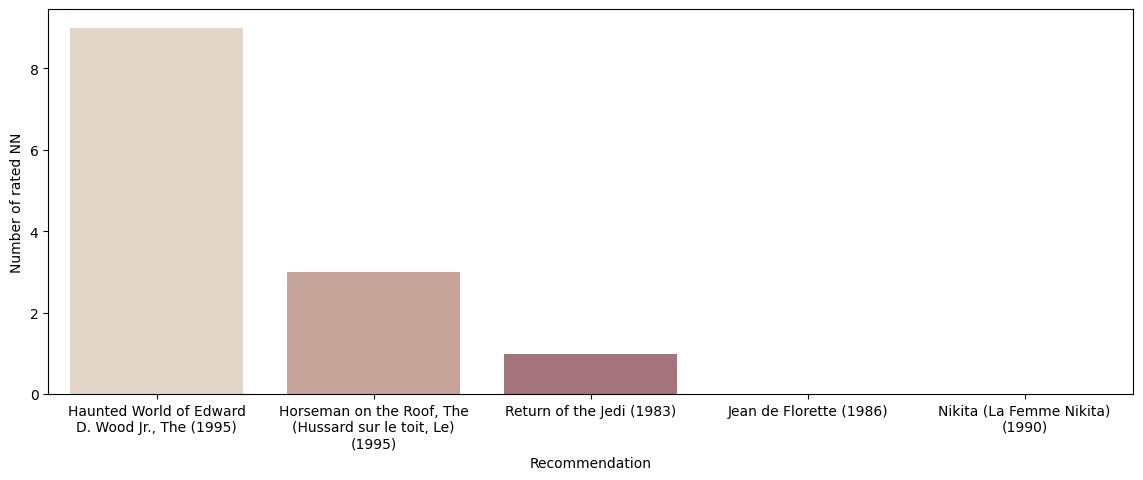

In [43]:
rated_items = np.nonzero(rating_mat[UIDX])[1]
n_nearest_neighbors = []
for rec in recommendations[:TOPK]:
  nearest_neighbors = np.argsort(iknn_adjusted.sim_mat[rec].A.ravel())[-K:]
  n_nearest_neighbors.append(len(np.intersect1d(nearest_neighbors, rated_items)))
rec_df["Number of rated NN"] = n_nearest_neighbors

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x="Recommendation", y="Number of rated NN", data=rec_df, palette="ch:.25", ax=ax);
ax.set_xticklabels(textwrap.fill(x.get_text(), 25) for x in ax.get_xticklabels());

In questo caso, la raccomandazione principale è *Haunted World of Edward D. Wood Jr., The (1995)*, e 9 film tra i suoi 50 vicini più simili sono stati valutati (probabilmente guardati) dall'utente.